# Sign Language Translator

## Importamos las librerias

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, preprocessing, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

## Importamos los datos

Reescalamos los datos para normalizarlos

In [83]:
gen = ImageDataGenerator(rescale=1/255)

Ahora cargamos los datos usando flow_from_directory() para que ademas pille las categorias de las imagenes.

In [84]:
train = gen.flow_from_directory('../Data/Train', color_mode='rgb', batch_size=32, class_mode='categorical', target_size = (480,720))
test = gen.flow_from_directory('../Data/Test', color_mode='rgb', batch_size=32, class_mode='categorical', target_size = (480,720))

Found 1420 images belonging to 24 classes.
Found 368 images belonging to 24 classes.


## Creamos el primer modelo

In [85]:
model = models.Sequential()
model.add(layers.Conv2D(8,(4,4),activation='relu',input_shape=(480, 720, 3)))
model.add(layers.MaxPooling2D((5,5)))
model.add(layers.Conv2D(8,(4,4),activation='relu'))
model.add(layers.MaxPooling2D((5,5)))
model.add(layers.Flatten())
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dense(24, activation='softmax'))

In [86]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 477, 717, 8)       392       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 95, 143, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 92, 140, 8)        1032      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 18, 28, 8)        0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 4032)              0         
                                                                 
 dense_38 (Dense)            (None, 6)               

In [87]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_final = model.fit(train, epochs = 10,batch_size = 16,validation_data=test)

Epoch 1/10
45/45 [==============================] - 114s 2s/step - loss: 3.1842 - accuracy: 0.0817 - val_loss: 3.1747 - val_accuracy: 0.0842
Epoch 2/10
45/45 [==============================] - 105s 2s/step - loss: 3.1731 - accuracy: 0.0873 - val_loss: 3.1716 - val_accuracy: 0.0842
Epoch 3/10
45/45 [==============================] - 119s 3s/step - loss: 3.1698 - accuracy: 0.0873 - val_loss: 3.1687 - val_accuracy: 0.0842
Epoch 4/10
45/45 [==============================] - 110s 2s/step - loss: 3.1669 - accuracy: 0.0873 - val_loss: 3.1660 - val_accuracy: 0.0842
Epoch 5/10
45/45 [==============================] - 107s 2s/step - loss: 3.1640 - accuracy: 0.0873 - val_loss: 3.1634 - val_accuracy: 0.0842
Epoch 6/10
45/45 [==============================] - 112s 2s/step - loss: 3.1613 - accuracy: 0.0873 - val_loss: 3.1610 - val_accuracy: 0.0842
Epoch 7/10
45/45 [==============================] - 109s 2s/step - loss: 3.1589 - accuracy: 0.0873 - val_loss: 3.1589 - val_accuracy: 0.0842
Epoch 8/10
45

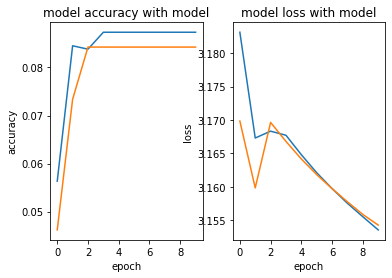

In [8]:
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy with model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend
plt.sca(axarr[1]); 
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss with model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Modelo con VGG16

In [9]:
#generamos la red neuronal, haciendo el uso del transfern learning, con la VGG16
VGG16_model = VGG16(input_shape = (480, 720, 3),
                    include_top = False, weights = 'imagenet')
VGG16_model.summary()

58900480/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 720, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 480, 720, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 480, 720, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 240, 360, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 240, 360, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 240, 360, 128)     147584    
                                                              

In [10]:
#Congelamos las capas de base convolucional con el fin de evitar que sus pesos sean actualizados
#durante el entrenamiento
for i in VGG16_model.layers:
    layers.trainable = False

In [11]:
#Ahora creamos nuestro modelo con VGG16
tfVGG16_model = keras.Sequential([
    VGG16_model,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(24, activation = 'softmax'),
])
tfVGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 15, 22, 512)       14714688  
                                                                 
 flatten_1 (Flatten)         (None, 168960)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                10813504  
                                                                 
 dense_3 (Dense)             (None, 24)                1560      
                                                                 
Total params: 25,529,752
Trainable params: 25,529,752
Non-trainable params: 0
_________________________________________________________________


In [12]:
tfVGG16_model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

In [13]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=2, 
    restore_best_weights=True,
)

In [ ]:
#Entrenamos nuestras redes neuronales
history_final = tfVGG16_model.fit(train, epochs = 15,batch_size = 16,callbacks=[early_stopping],
                         validation_data=test)

Epoch 1/15


# Modelo Reduciendo Categorias

In [15]:
gen = ImageDataGenerator(rescale=1/255)

In [16]:
train_voc = gen.flow_from_directory('../Data_Voc/Train', color_mode='rgb', batch_size=32, class_mode='categorical', target_size = (480,720))
test_voc = gen.flow_from_directory('../Data_Voc/Test', color_mode='rgb', batch_size=32, class_mode='categorical', target_size = (480,720))

Found 346 images belonging to 5 classes.
Found 88 images belonging to 5 classes.


In [17]:
model = models.Sequential()
model.add(layers.Conv2D(8,(4,4),activation='relu',input_shape=(480, 720, 3)))
model.add(layers.MaxPooling2D((5,5)))
model.add(layers.Conv2D(8,(4,4),activation='relu'))
model.add(layers.MaxPooling2D((5,5)))
#model.add(Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 477, 717, 8)       392       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 95, 143, 8)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 92, 140, 8)        1032      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 18, 28, 8)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4032)              0         
                                                                 
 dense_6 (Dense)             (None, 6)                

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history_final = model.fit(train_voc, epochs = 5,batch_size = 16,validation_data=test_voc)

Epoch 1/5
11/11 [==============================] - 29s 3s/step - loss: 1.6185 - accuracy: 0.2775 - val_loss: 1.6068 - val_accuracy: 0.3523
Epoch 2/5
11/11 [==============================] - 28s 2s/step - loss: 1.6054 - accuracy: 0.3584 - val_loss: 1.6042 - val_accuracy: 0.3523
Epoch 3/5
11/11 [==============================] - 27s 2s/step - loss: 1.6029 - accuracy: 0.3584 - val_loss: 1.6017 - val_accuracy: 0.3523
Epoch 4/5
11/11 [==============================] - 27s 2s/step - loss: 1.6001 - accuracy: 0.3584 - val_loss: 1.5995 - val_accuracy: 0.3523
Epoch 5/5
11/11 [==============================] - 28s 3s/step - loss: 1.5978 - accuracy: 0.3584 - val_loss: 1.5973 - val_accuracy: 0.3523


# Modelo con 2 clases

In [68]:
gen = ImageDataGenerator(rescale=1/255)

In [69]:
train_bi = gen.flow_from_directory('../Data_Bi/Train', color_mode='rgb', batch_size=32, class_mode='categorical', target_size = (480,720))
test_bi = gen.flow_from_directory('../Data_Bi/Test', color_mode='rgb', batch_size=32, class_mode='categorical', target_size = (480,720))

Found 230 images belonging to 2 classes.
Found 58 images belonging to 2 classes.


In [70]:
model = models.Sequential()
model.add(layers.Conv2D(4,(3,3),activation='relu',input_shape=(480, 720, 3)))
model.add(layers.MaxPooling2D((6,6)))
model.add(layers.Conv2D(6,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((6,6)))
#model.add(Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [71]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 478, 718, 4)       112       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 79, 119, 4)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 77, 117, 6)        222       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 12, 19, 6)        0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 1368)              0         
                                                                 
 dense_32 (Dense)            (None, 5)               

In [72]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [75]:
history_final = model.fit(train_bi, epochs = 15,batch_size = 16,validation_data=test_bi)

Epoch 1/15
8/8 [==============================] - 13s 2s/step - loss: 0.6278 - accuracy: 0.7565 - val_loss: 0.6383 - val_accuracy: 0.5345
Epoch 2/15
8/8 [==============================] - 12s 1s/step - loss: 0.6138 - accuracy: 0.7087 - val_loss: 0.6407 - val_accuracy: 0.5172
Epoch 3/15
8/8 [==============================] - 12s 2s/step - loss: 0.5972 - accuracy: 0.7435 - val_loss: 0.6224 - val_accuracy: 0.5172
Epoch 4/15
8/8 [==============================] - 12s 1s/step - loss: 0.5771 - accuracy: 0.7609 - val_loss: 0.6164 - val_accuracy: 0.5172
Epoch 5/15
8/8 [==============================] - 13s 2s/step - loss: 0.5635 - accuracy: 0.8043 - val_loss: 0.5905 - val_accuracy: 0.5517
Epoch 6/15
8/8 [==============================] - 13s 2s/step - loss: 0.5466 - accuracy: 0.8478 - val_loss: 0.6122 - val_accuracy: 0.5517
Epoch 7/15
8/8 [==============================] - 12s 2s/step - loss: 0.5328 - accuracy: 0.8391 - val_loss: 0.5876 - val_accuracy: 0.5690
Epoch 8/15
8/8 [==================

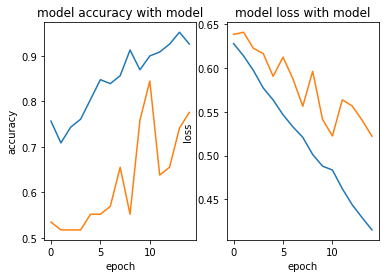

In [76]:
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy with model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend
plt.sca(axarr[1]); 
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss with model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()